<a class="anchor" id="top"></a>
# Working with Wikimedia data – an intro to Dumps & APIs

## Introduction

Data from Wikimedia projects is open-licenced and publicly available, and can be accessed in a variety of ways:

* Data dumps in SQL or XML format
* Database replicas thorough Toolforge, PAWS, or Quarry
* API endpoints


This is not an exhaustive list – additional info can be found on this [meta-wiki page](https://meta.wikimedia.org/wiki/Research:Data). Info about the database schema can be [found here](https://www.mediawiki.org/wiki/Manual:Database_layout).

In this tutorial, we'll extract and combine data from the SQL and XML dumps to answer the following question: **Has editing Wikipedia pages shifted to mobile -- i.e. editing on one's mobile device instead of a desktop computer?**
We'll also see how the same data can be accessed through the [Revisions API](https://www.mediawiki.org/wiki/API:Revisions) endpoint.

Mobile edits can be identified via a specific [edit tag](https://en.wikipedia.org/wiki/Wikipedia:Tags) that is recorded with an edit, and each Wikipedia page has an edit (revision) history attached to it. Data on what tags are associated with which edits are available via [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Change_tag_table) or the [API](https://www.mediawiki.org/wiki/API:RecentChanges).

**In this tutorial, you’ll learn:**

* How to access the **revision history** of Wikipedia pages through both the data dumps and the APIs
* How to extract the revisions that match a given tag
* How to parse Wikipedia **SQL and XML data dumps** and aggregate the data we need in a Pandas dataframe
* How to analyze and visualize the tagged edit data

## Table of Contents
   
##### Dumps:
1. [Accessing Tagged Edits via Dumps](#dump-access)
##### SQL
2. [Converting SQL data to Pandas DataFrame](#sql-to-df)
3. [Exploring the Change Tag Dataset](#exploring-change-tag-ds)
4. [Selecting mobile edits from the change tag dataset](#selecting-mobile-edits)
##### XML
5. [Working with XML dumps](#xml-dumps)
6. [Exploring the revision history](#exploring-revision-history)
7. [Extracting data from the revision history dump](#extracting-revision-data)
##### API
8. [Accessing the Edit Tag APIs](#api-access)
##### Data Analysis & Summary
9. [Example Analyses of Edit Tag Data](#analyses)
10. [Summary](#summary)

<a class="anchor" id="dump-access"></a>
## Accessing Tagged Edits via Dumps

For the purpose of this tutorial, we'll work with data from the [Simple English Wikipedia](https://simple.wikipedia.org), an English edition of Wikipedia written in basic English aimed at people who are learning English. The **database name** for this Wikipedia is `simplewiki`. If we wanted to access data from another language version, say English or Arabic Wikipedia, the database names would be `enwiki` and `arwiki` respectively. You can find the database names for other Wikimedia projects [here](https://www.mediawiki.org/w/api.php?action=sitematrix).

Every language on Wikipedia has its own [edit tag](https://en.wikipedia.org/wiki/Special:Tags) tables and [history dumps](https://dumps.wikimedia.org/archive/). In the case of Simplewiki, these can be found [here](https://dumps.wikimedia.org/simplewiki/latest/).

Next, we're going to look at how we can access the files we'll need for our analyses.

### Accessing data from SQL dump files

The two SQL database tables we're interested in are called `change_tag_def` and `change_tag`.
We'll use the Python [`mwsql` library](https://mwsql.readthedocs.io/en/latest/) to access the dump files from these tables.

In [2]:
# install mwsql
!pip install mwsql

  Using cached mwsql-0.1.3-py3-none-any.whl (275 kB)
  Using cached wget-3.2-py3-none-any.whl
You should consider upgrading via the '/srv/paws/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# import modules
from mwsql import load, Dump

In [4]:
# use the `load()` function to access the dump files. If you're in a Wikimedia hosted
# environment such as PAWS or Toolforge, you have direct access to these files.
# Otherwise, they will be downloaded to your current working directory.
change_tag_def_file = load('simplewiki', 'change_tag_def')
change_tag_file = load('simplewiki', 'change_tag')

# create Dump objects from the files
change_tag_def_dump = Dump.from_file(change_tag_def_file)
change_tag_dump = Dump.from_file(change_tag_file)

# examine the `change_tag_def` dump
change_tag_def_dump.head()

['ctd_id', 'ctd_name', 'ctd_user_defined', 'ctd_count']
['1', 'mw-replace', '0', '10822']
['2', 'visualeditor', '0', '313616']
['3', 'mw-undo', '0', '61959']
['4', 'mw-rollback', '0', '73951']
['5', 'mobile edit', '0', '244240']
['6', 'mobile web edit', '0', '236538']
['7', 'very short new article', '0', '29233']
['8', 'visualeditor-wikitext', '0', '21536']
['9', 'mw-new-redirect', '0', '32344']
['10', 'visualeditor-switched', '0', '18419']


This dataset gives us information about all the different tags that can be applied to an edit. 

How do we interpret this data? Let's take the third record `['3', 'mw-undo', '0', '61959']` as an example:

  * **'3'**:         unique ID for the tag 
  * **'mw-undo'**: descriptive name -- in this case, the tag is applied when an editor uses the "mw-undo" button to revert an edit
  * **'0'**:         not defined by a user
  * **'61959'**:   has been used for 61959 edits in Simple English Wikipedia

For additional tags and extended descriptions on Simple English Wikipedia, see [this link](https://simple.wikipedia.org/wiki/Special:Tags). 

<a class="anchor" id="sql-to-df"></a>
### Converting SQL data to Pandas DataFrame

We'll now read all the records from the dump into a Pandas dataframe.

In [5]:
import numpy as np
import pandas as pd

In [6]:
# create a generator from the rows, converting each field to the correct data type
rows = change_tag_def_dump.rows(convert_dtypes=True)

# create a DataFrame from the rows
columns = change_tag_def_dump.col_names
change_tag_def_df = pd.DataFrame(rows, columns=columns)

# display first five records
change_tag_def_df.head()

,ctd_id,ctd_name,ctd_user_defined,ctd_count
0,1,mw-replace,0,10822
1,2,visualeditor,0,313616
2,3,mw-undo,0,61959
3,4,mw-rollback,0,73951
4,5,mobile edit,0,244240


The tag we are interested in is `mobile edit`. We can see that it has `ctd_id` 5. This will be useful in the next step when we filter the change tag dataset for this specific tag. 

Next, we'll take a look at the **change tag dataset** and convert it into a Pandas DataFrame.

<a class="anchor" id="exploring-change-tag-ds"></a>
### Exploring the Change Tag Dataset

In [7]:
# create a generator from the rows, converting each field to the correct data type
# rows = change_tag_dump.rows(convert_dtypes=True)
rows = change_tag_dump.rows(convert_dtypes=True)

# create a DataFrame from the rows
change_tag_df = pd.DataFrame(rows, columns=change_tag_dump.col_names)

# display df info
change_tag_df.info()

# inspect top rows
change_tag_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443218 entries, 0 to 1443217
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   ct_id      1443218 non-null  int64 
 1   ct_rc_id   1443218 non-null  object
 2   ct_log_id  1443218 non-null  object
 3   ct_rev_id  1443218 non-null  object
 4   ct_params  1443218 non-null  object
 5   ct_tag_id  1443218 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 66.1+ MB


,ct_id,ct_rc_id,ct_log_id,ct_rev_id,ct_params,ct_tag_id
0,1,2515963,,2489613,,39
1,2,2518288,,2491923,,39
2,3,2518475,,2492098,,39
3,4,2518988,,2492598,,39
4,5,2522990,,2496471,,39


We see here that there are roughly 1.4M entries in this dataset and six columns. The last one, `ct_tag_id`, is the one that relates this table to the one containing the tag description data we just explored.

The first row `[1, 2515963,  , 2489613,  , 39]` can be interpreted as:
  * **1**:         unique ID -- can be ignored
  * **2515963**:   links to [recent changes table](https://www.mediawiki.org/wiki/Manual:Recentchanges_table#rc_id) but can be ignored for now
  * **\<empty>**:      doesn't link to [logging table](https://www.mediawiki.org/wiki/Manual:Logging_table#log_id)
  * **2489613**:   revision ID of an edit that was tagged -- this will allow us to tie tags to the revision history XML dump
  * **\<empty>**:      additional parameters that can be ignored
  * **39**:        the tag that was applied to edit 2489613 was #39 (which happens to be 'New user creating interrogative pages' if we check the change_tag_def table above)

The columns we need are `ct_rev_id`, and `ct_tag_id` where the ID is 5 (mobile edit). In the next step, we'll subset this dataset to get only the data related to mobile edits.

<a class="anchor" id="selecting-mobile-edits"></a>
### Selecting mobile edits from the change tag dataset

In [8]:
# keep only the mobile edits
mobile_edit_ids = change_tag_df[change_tag_df['ct_tag_id'] == 5]

# clean up dataset to contain only relevant information, drop null values
mobile_edit_ids = mobile_edit_ids.replace(r'^\s*$', np.NaN, regex=True)  # replace empty string with np.Nan
mobile_edit_ids = mobile_edit_ids[['ct_id', 'ct_rev_id', 'ct_tag_id']].dropna().astype('int')

# as a sanity check, let's make sure all the `ct_tag_ids` have the value 5
assert len(mobile_edit_ids) == len(mobile_edit_ids[mobile_edit_ids['ct_tag_id'] == 5])

# display info
mobile_edit_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234332 entries, 4855 to 1443217
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   ct_id      234332 non-null  int64
 1   ct_rev_id  234332 non-null  int64
 2   ct_tag_id  234332 non-null  int64
dtypes: int64(3)
memory usage: 7.2 MB


We can see that there are approximately 235k mobile edits (or that were tagged as such, at least) in the revision history of Simplewiki. The next step is to gather data about these edits from the XML revision history dump.

<a class="anchor" id="xml-dumps"></a>
## Working with XML dumps

To begin, we will inspect what the top of the history dump looks like. The file we need is 'simplewiki-latest-stub-meta-history.xml.gz'. Even though it's an XML file, we can still use the convenience functions `load()` and `head()` from the `mwsql` library to open it and print the first part.

In [9]:
from mwsql import head

In [10]:
# load dump file
history_dump_file = load('simplewiki', 'stub-meta-history', extension='xml')

# print first part
head(history_dump_file, 63)

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="en">
<siteinfo>
<sitename>Wikipedia</sitename>
<dbname>simplewiki</dbname>
<base>https://simple.wikipedia.org/wiki/Main_Page</base>
<generator>MediaWiki 1.37.0-wmf.19</generator>
<case>first-letter</case>
<namespaces>
<namespace key="-2" case="first-letter">Media</namespace>
<namespace key="-1" case="first-letter">Special</namespace>
<namespace key="0" case="first-letter" />
<namespace key="1" case="first-letter">Talk</namespace>
<namespace key="2" case="first-letter">User</namespace>
<namespace key="3" case="first-letter">User talk</namespace>
<namespace key="4" case="first-letter">Wikipedia</namespace>
<namespace key="5" case="first-letter">Wikipedia talk</namespace>
<namespace key="6" case="first-letter">File</namespace>
<namespace key="7"

After some metadata, we can see there is a page object with some metadata about the page,
and then a list of revisions from oldest to newest where each revision is an edit and metadata about that edit.

The start of the data for the April page above can also be viewed [here](https://simple.wikipedia.org/w/index.php?title=April&action=history), and its metadata [here](https://simple.wikipedia.org/w/index.php?title=April&action=info).

We will use the `mwxml` library to parse Wikimedia XML files. This library is directly accessible from PAWS and can otherwise be installed with `pip install mwxml`. The documentation can be found [here](https://pythonhosted.org/mwxml/).

We will now read the XML dump file into an `mwxml Dump` object and inspect it.

<a class="anchor" id="exploring-revision-history"></a>
### Exploring the revision history

In [11]:
import gzip
from mwxml import Dump

# construct dump file generator
with gzip.open(history_dump_file) as dump_file:
    history_dump = Dump.from_file(dump_file)

# print the first page object, corresponding to the 'April' page we just saw above
pages = history_dump.pages
first_page = next(pages)
print(first_page)

Page(id=1, title='April', namespace=0, redirect=None, restrictions=[])


In [12]:
# print the first three revisions for the 'April' page
n = 3
for revision in first_page:
    print(revision, end='\n\n')
    n -= 1
    if n == 0:
        break

Revision(id=2130, timestamp=Timestamp('2003-03-27T09:24:48Z'), user=User(id=667428, text='Ams80'), page=Page(id=1, title='April', namespace=0, redirect=None, restrictions=[]), minor=False, comment='Edited from English Wikipedia', text=None, bytes=724, sha1='g1vldyqwrp9b6ot9f4t27k5n2lmibva', parent_id=None, model='wikitext', format='text/x-wiki', deleted=Deleted(text=False, comment=False, user=False, restricted=None))

Revision(id=4183, timestamp=Timestamp('2003-12-23T13:23:09Z'), user=User(id=None, text='193.226.99.14'), page=Page(id=1, title='April', namespace=0, redirect=None, restrictions=[]), minor=False, comment=None, text=None, bytes=754, sha1='ftj0q1qjtfcfh679tnugw3n7hyfeswv', parent_id=2130, model='wikitext', format='text/x-wiki', deleted=Deleted(text=False, comment=False, user=False, restricted=None))

Revision(id=5043, timestamp=Timestamp('2004-03-08T17:09:24Z'), user=User(id=11, text='HasharBot~simplewiki'), page=Page(id=1, title='April', namespace=0, redirect=None, restrict

Note that while the raw XML dump lists the revisions from newest to oldest, here they are returned in reverse order, from oldest to newest. 

Next, we will loop through the history dump and record how many mobile vs. non-mobile edits were made each year. Each `Revision` has an `id` and a `timestamp` associated. The `id` will make it possible for us to link each revision to the `mobile_edit_ids` dataframe we created earlier. We will also extract the year from the timestamp.

<a class="anchor" id="extracting-revision-data"></a>
### Extracting data from the revision history dump

As the dump file is quite big (~470M), iterating through it may take quite a while. To speed things up a bit, we will focus only on articles and ignore talk pages, etc. You can expect this to take around 10-15 minutes.

In [15]:
# define a funciton to extract edit data
def get_edit_data(dump, filter_by, page_limit=None):
    """Extract mobile tag data by year"""
    
    result_dict = {}
    n_pages = 0
    # iterate through pages
    for page in dump.pages:
        # filter for articles via namespace
        if page.namespace == 0:
            # iterate through a page's revisions
            n_pages += 1
            if page_limit and n_pages >= page_limit:
                return result_dict
            for revision in page:
                # get the year the revision was made
                year = int(str(revision.timestamp)[:4])
                if year not in result_dict:
                    result_dict[year] = {'mobile': 0, 'non-mobile': 0}
                # check if the revision was mobile or not
                if revision.id in filter_by:
                    result_dict[year]['mobile'] += 1
                else:
                    result_dict[year]['non-mobile'] += 1
    return result_dict

# convert revision ids to set for faster lookup
mobile_edits = set(mobile_edit_ids['ct_rev_id'])

# recreate the history dump generator as we previously used the `next` method on it.
with gzip.open(history_dump_file) as dump_file:
    history_dump = Dump.from_file(dump_file)
    result_dict = get_edit_data(history_dump, mobile_edits)

In [16]:
# sort results by year in ascending order
result_dict_sorted = {}
for key, val in sorted(result_dict.items()):
    result_dict_sorted[key] = val
    
result_dict_sorted

{2001: {'mobile': 0, 'non-mobile': 21},
 2002: {'mobile': 0, 'non-mobile': 82},
 2003: {'mobile': 0, 'non-mobile': 2110},
 2004: {'mobile': 0, 'non-mobile': 15033},
 2005: {'mobile': 0, 'non-mobile': 42946},
 2006: {'mobile': 0, 'non-mobile': 153928},
 2007: {'mobile': 0, 'non-mobile': 271986},
 2008: {'mobile': 0, 'non-mobile': 387140},
 2009: {'mobile': 0, 'non-mobile': 398010},
 2010: {'mobile': 0, 'non-mobile': 410409},
 2011: {'mobile': 0, 'non-mobile': 442907},
 2012: {'mobile': 0, 'non-mobile': 549644},
 2013: {'mobile': 623, 'non-mobile': 427940},
 2014: {'mobile': 2264, 'non-mobile': 193420},
 2015: {'mobile': 8866, 'non-mobile': 169773},
 2016: {'mobile': 14273, 'non-mobile': 145720},
 2017: {'mobile': 21987, 'non-mobile': 186184},
 2018: {'mobile': 28107, 'non-mobile': 222837},
 2019: {'mobile': 36107, 'non-mobile': 186409},
 2020: {'mobile': 35233, 'non-mobile': 283901},
 2021: {'mobile': 35508, 'non-mobile': 279865}}

We now have the necessary data, although before moving on to the analysis, we will take a quick look at another way of accessing the revision data.

Even though we substantially reduced the number of pages and revisions we had to loop through by restricting ourselves to the article namespace, the code still took a while to run. If we are interested in only a few, or a small subset of, pages, this method of accessing the data is inefficient. Is there a better way? In the next section, we will see how we can use the APIs for retrieving revision history data.

<a class="anchor" id="api-access"></a>
## Accessing the Edit Tag APIs
The [Revisions API](https://www.mediawiki.org/wiki/API:Revisions) can be a much simpler way to access data about edit tags for a given article if you know what articles you are interested in and are interested in relatively few articles (e.g., hundreds or low thousands).

NOTE: the APIs are up-to-date while the Mediawiki dumps are always at least several days behind -- i.e. for specific snapshots in time -- so the data you get from the Mediawiki dumps might be different from the APIs if edits have been made to a page in the intervening days.

Next, we'll access the Simplewiki page [Pizza](https://simple.wikipedia.org/wiki/Pizza) by iterating through the XML dump exactly like we just did. Then, we'll retrieve the same data by using the API and compare the results.

To access the APIs, we'll use the `mwapi` library. See [documentation here](https://pypi.org/project/mwapi/).

In [17]:
import mwapi

In [ ]:
# define a function to extract page data
def get_page_data(dump, filter_by, page_title, year):
    """Extract mobile tag data for a specific pageand year"""
    
    edits = {'mobile': 0, 'non-mobile': 0}
    page_found = False

    # iterate through pages
    for page in dump.pages:
        if page_found:
            return edits
        if page.title == page_title:
            page_found = True
            # iterate through the revisions
            for revision in page:
                # extract year from timestamp
                year = int(str(revision.timestamp)[:4])
                # filter for edits from 2020 and check if the revision was mobile
                if year == 2020 and revision.id in filter_by:
                    edits['mobile'] += 1
                elif year == 2020:
                    edits['non-mobile'] += 1
    return edits

In [19]:
article_title = 'Pizza'
year = 2000

# recreate history dump object from file
with gzip.open(history_dump_file) as dump_file:
    history_dump = Dump.from_file(dump_file)
    edits_2000 = get_page_data(history_dump, mobile_edits, article_title, year)

# display results
edits_2000

{'mobile': 4, 'non-mobile': 40}

We see that there were a total of 44 revisions of the article `Pizza` made in 2020 - 4 mobile and 40 non-mobile.

Now, we are going to request this information from the API. You can find info about the Revisions endpoint [here](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Brevisions). For more details, check out [this link](https://www.mediawiki.org/wiki/API:Revisions).

In [21]:
# configure API session parameters

# user_agent helps identify the request if there's an issue and is best practice
TUTORIAL_LABEL = 'Edit Tag API tutorial (mwapi)'

# NOTE: it's best practice to include a contact email in user agents
CONTACT_EMAIL = 'your@email.com'

# simplewiki -> simple.wikipedia 
SITENAME = 'simple.wikipedia'

# initiate API session
session = mwapi.Session(f'https://{SITENAME}.org', user_agent='{TUTORIAL_LABEL} -- {CONTACT_EMAIL}')

# define query parameters
params = {'action': 'query',
          'prop': 'revisions',
          'titles': f'{article_title}',
          'rvprop': 'timestamp|ids|user|tags',
          'rvslots': 'main',
          'rvlimit': 'max',
          "formatversion": "2",
          'format': 'json'}

In [22]:
# get all edits (and tags) for the article 'Pizza' made in 2020 via the API

# submit query
data = session.get(params)

# get revisions
revs = data['query']['pages'][0]['revisions']

# filter for 2020 revisions
api_edits_2020 = [rev for rev in revs if '2020' in rev['timestamp']]

In [23]:
# examine API results and compare the number of edits from mobile
# with the data from the Mediawiki dump

mobile_api_edits_2020 = [e for e in api_edits_2020 if 'mobile edit' in e['tags']]
total_edits = len(api_edits_2020)
num_mobile_edits = len(mobile_api_edits_2020)
print(f"We've retrieved a total of {total_edits} edits for the page \"{article_title}\" by using the API, of which {num_mobile_edits} were mobile edits.")

We've retrieved a total of 44 edits for the page "Pizza" by using the API, of which 4 were mobile edits.


The results from the API are consistent with what we got earlier from the XML history dump.

<a class="anchor" id="analyses"></a>
## Example Analyses of Edit Tag Data
Here we show some examples of things we can do with the data that we gathered about the edit tags for various Wikipedia articles.

To start, we will answer the question we posed at the beginning of this tutorial: **How has mobile editing changed over the last ~20 years?** We will create a graph from the dictionary containing the results we obtained earlier from the SQL dump dataset.

### Evolution of Mobile Editing

<AxesSubplot:>

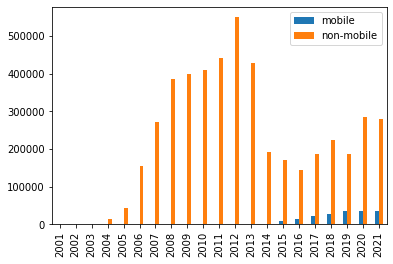

In [26]:
edit_data = pd.DataFrame.from_dict(result_dict_sorted, orient='index')
edit_data.plot(kind='bar')

From the graph, it looks like there were no mobile edits before 2015, although if we look at the dictionary containing the results, we can see that the first mobile edits date from 2012 - they're just too few to be visible on the scale of the graph. This is about when smartphones started becoming mainstream so it would make sense.

On the non-mobile side, editing reached a peak in 2012. By then, Wikipedia had existed for ~10 years - perhaps the bulk of the editing needed had been finalized by then.

Overall, even though the number of mobile edits has been increasing since the beginning, it still represents a very small proportion of the total edits.

### Are Editors Contributing Equally? 

Another question we could attempt to answer with this data is how edits are distributed among Wikipedia contributors. The [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle), otherwise known as the 80/20 rule states that for many outcomes, roughly 80% of consequences come from 20% of the causes. Many natural phenomena have been shown to exhibit such a distribution and it would be interesting to see if it applies here too. In other words, **Is a small subset of Wikipedia editors contributing most of the work, or is the distribution more even?**

For this analysis, we will again loop through the XML revision dump, but instead of the `year`, we will now extract the `user_ids`. To save time, we will only analyze the data from the first 2000 pages in the article namespace of Simplewiki. While this "sampling method" may not constitute rigorous data science, it is good enough for exploratory analysis. We will again keep track of whether the edits were tagged as mobile edits or not so that we can compare the two categories.

Next, we will define a custom function to extract the data we need and use it to loop through the revisions.

In [27]:
# define a function to extract mobile tag data by user
def get_user_data(dump, filter_by, page_limit=None):
    
    result_dict = {}
    n_pages = 0

    # Iterate through pages
    for page in dump.pages:
        # Filter for articles via namespace
        if page.namespace == 0:
            n_pages += 1
            if page_limit and n_pages >= page_limit:
                return result_dict
            # Iterate through a page's revisions
            for revision in page:
                # Extract user_id
                if revision.user:
                    user_id = revision.user.id
                # Ignore anonymous users
                if user_id is not None:
                    if user_id not in result_dict:
                        result_dict[user_id] = {'mobile': 0, 'non-mobile': 0}
                    # Check if the revision was mobile or not
                    if revision.id in filter_by:
                        result_dict[user_id]['mobile'] += 1
                    else:
                        result_dict[user_id]['non-mobile'] += 1
                    
    return result_dict

In [28]:
# extract user data from the dump
with gzip.open(history_dump_file) as dump_file:
    history_dump = Dump.from_file(dump_file)
    result_dict = get_user_data(history_dump, filter_by=mobile_edits, page_limit=2000)

In [29]:
# turn dict into pd dataframe
user_df = pd.DataFrame.from_dict(result_dict, orient='index')

# split into mobile/non_mobile dataframes
user_df_mobile = user_df.drop('non-mobile', axis=1)
user_df_non_mobile = user_df.drop('mobile', axis=1)

# sort edits in descending order
user_df_mobile = user_df_mobile.sort_values(by='mobile', ascending=False)
user_df_non_mobile = user_df_non_mobile.sort_values(by='non-mobile', ascending=False)

# add a column to contain cumulative percentage of edits
user_df_mobile["cumulative %"] = user_df_mobile["mobile"].cumsum()/user_df["mobile"].sum() * 100
user_df_non_mobile["cumulative %"] = user_df_non_mobile["non-mobile"].cumsum()/user_df["non-mobile"].sum() * 100

# clean up the row index and labels
# mobile df
user_df_mobile.reset_index(level=0, inplace=True)
user_df_mobile = user_df_mobile.rename(columns={"mobile": "mobile edits","index": "user_id"})
# same for non-mobile df
user_df_non_mobile.reset_index(level=0, inplace=True)
user_df_non_mobile = user_df_non_mobile.rename(columns={"non-mobile": "non-mobile edits", "index": "user_id"})

In [31]:
# finally, we can take a look at the data
print(f"Data from {len(user_df_non_mobile)} users contributing a total of {user_df_non_mobile['non-mobile edits'].sum()} non-mobile edits:")
user_df_non_mobile.head()

Data from 12265 users contributing a total of 257633 non-mobile edits:


,user_id,non-mobile edits,cumulative %
0,10515,8745,3.394363
1,68157,6799,6.033389
2,40158,6660,8.618461
3,1144,6267,11.050991
4,16695,5700,13.263441


In [33]:
print(f"Data from {len(user_df_mobile)} users contributing a total of {user_df_mobile['mobile edits'].sum()} mobile edits:")
user_df_mobile.head()

Data from 12265 users contributing a total of 4982 mobile edits:


,user_id,mobile edits,cumulative %
0,70336,641,12.866319
1,768749,413,21.156162
2,1020280,263,26.435167
3,821211,150,29.446006
4,1055293,122,31.894821


From the tables above, we see that there is an extreme version of the Pareto principle at work here. In fact, the 5 most productive users have single-handedly contributed over 13% of the non-mobile edits! For mobile edits, this number is even higher at around 32%. 

To finish our analysis, we'll segment the data from the non-mobile dataset into bins containing 20% of the users each to get a better overview of the overall distribution. The distribution of the mobile edits is too left-skewed to visualize in this way, so we'll use bins of unequal sizes instead.

In [34]:
# non-mobile edits
print('Results for non-mobile edits:', end='\n\n')
print(pd.qcut(user_df_non_mobile['cumulative %'], 5, duplicates='drop').value_counts(sort=False, normalize=True).mul(100).round(1), end='\n\n')

# mobile edits
bins = [0,20,50,95,98,99,100]
print('Results for mobile edits:', end='\n\n')
print(pd.cut(user_df_mobile['cumulative %'], bins=bins).value_counts(sort=False, normalize=True).mul(100).round(2))

Results for non-mobile edits:

(3.3930000000000002, 95.18]    20.0
(95.18, 97.48]                 20.0
(97.48, 98.592]                20.0
(98.592, 99.544]               20.0
(99.544, 100.0]                20.0
Name: cumulative %, dtype: float64

Results for mobile edits:

(0, 20]       0.01
(20, 50]      0.26
(50, 95]      8.94
(95, 98]      1.22
(98, 99]      0.41
(99, 100]    89.16
Name: cumulative %, dtype: float64


The above results confirm our first impression – that is, a few users contribute disproportionately to the editing of Simplewiki. For non-mobile edits, we see that the top 20% of most productive editors contribute over 95% of all edits.

For mobile edits, the situation is even more extreme: ~10% of the editors contribute 99% of all edits.

<a class="anchor" id="summary"></a>
# Summary

In this tutorial, we explored how to gather and analyze Wikimedia data from different sources. Specifically, we focused on the revision history of articles from the Simple English Wikipedia and counted how many mobile vs. non-mobile edits there were.

From a practical point of view, we learned how to parse compressed files in SQL and XML dump format, and how to access data from the Wikimedia Revisions API.

Feel free to explore this tutorial further by exploring other tags, adding visualizations, or creating other datasets from the raw data. Some suggestions for further analyses:

* How many of the editors are bots vs. real people?
* We excluded revisions made by anonymous editors when gathering the data. Would including them change the results?
* Are mobile edits, on average, shorter than non-mobile ones?